In [50]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Task 1

## Task 1.1

TODO pokec

In [ ]:
#| echo: true
SEED = 42
generator = np.random.default_rng(SEED)
rng = lambda: generator.random()
rng_nn = lambda shape: generator.random(shape)
dist = lambda n1, n2: np.sqrt((n1[0] - n2[0])**2 + (n1[1] - n2[1])**2)
p = lambda d, alpha, beta : beta * np.exp(-alpha * d)

def KaiserHilgetag(alpha = 1, beta = 1, N = 100):
    adjacency = np.zeros((N, N))
    neurons = [(rng(), rng())]
    while(len(neurons) < N):
        new_neuron = (rng(), rng())
        dists = [dist(new_neuron, n) for n in neurons]
        neighbours = [i for i, d in enumerate(dists) if random.random() < p(d, alpha, beta)]
        if len(neighbours) > 0:
            neurons.append(new_neuron)
            for i in neighbours:
                adjacency[i, len(neurons)-1] = 1
                adjacency[len(neurons)-1, i] = 1

    return adjacency, neurons

## Task 1.2

TODO pokec

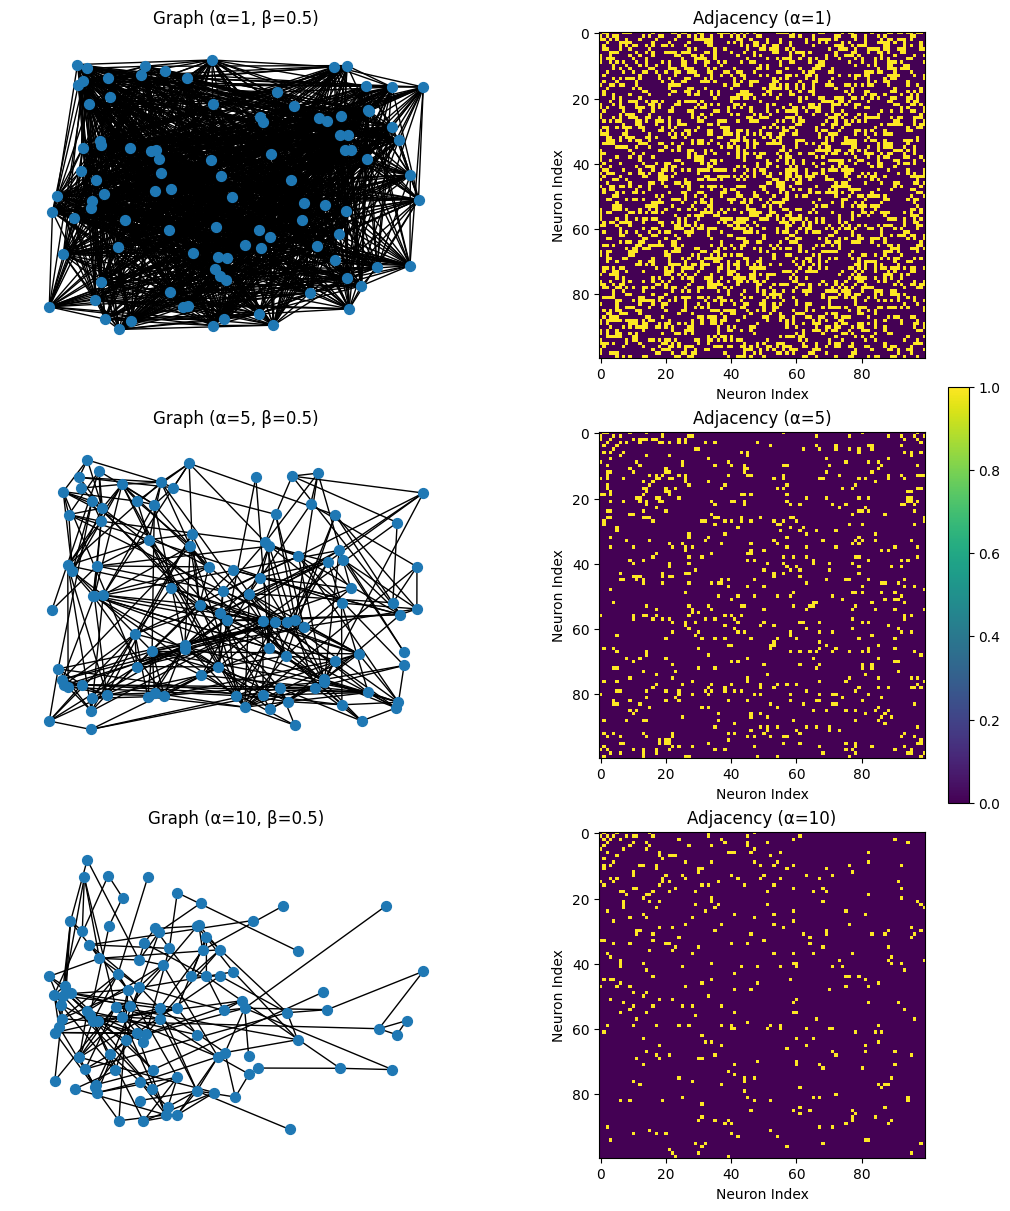

In [52]:
def plot_graph(ax, G, positions, title="Graph"):
    nx.draw(G,pos={j: positions[j] for j in range(len(positions))},node_size=50,with_labels=False,ax=ax)
    ax.set_title(title)
    ax.set_axis_off()


def plot_adjacency_matrix(ax, adjacency, title="Adjacency Matrix"):
    im = ax.imshow(adjacency)
    ax.set_title(title)
    ax.set_xlabel("Neuron Index")
    ax.set_ylabel("Neuron Index")
    return im


fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(10, 12))

results = [
    KaiserHilgetag(alpha=1, beta=0.5, N=100),
    KaiserHilgetag(alpha=5, beta=0.5, N=100),
    KaiserHilgetag(alpha=10, beta=0.5, N=100)
]
alpha_values = [1, 5, 10]

for i, (adjacency, positions) in enumerate(results):
    G = nx.from_numpy_array(adjacency)
    plot_graph( axes[i, 0],G,positions,title=f"Graph (α={alpha_values[i]}, β=0.5)")
    im = plot_adjacency_matrix(axes[i, 1],adjacency,title=f"Adjacency (α={alpha_values[i]})")

# optional single colorbar for all adjacency matrices
fig.colorbar(im, ax=axes[:, 1], fraction=0.046)

plt.show()


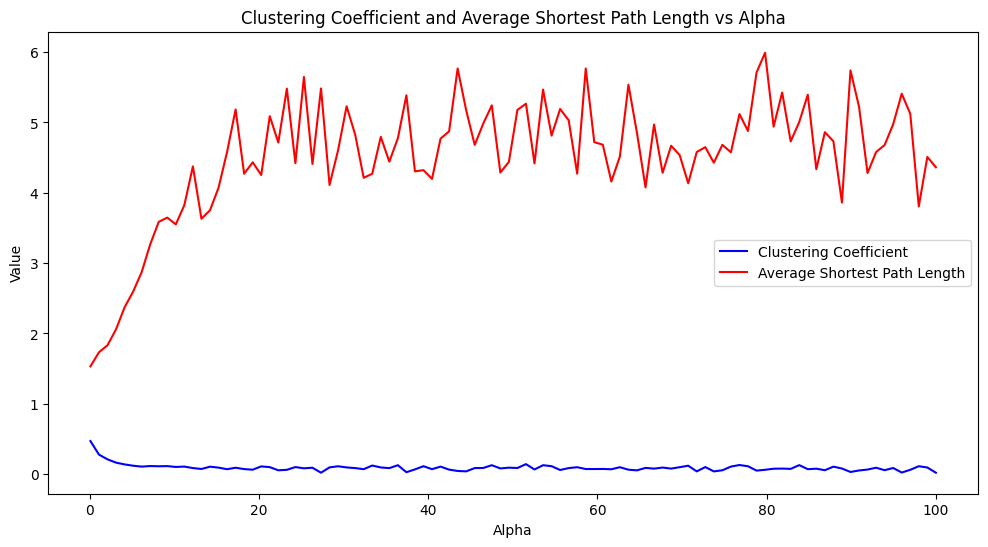

In [53]:
cluster_coefficients = []
average_shortest_paths = []
alphas = np.linspace(0.1, 100, 100)

for i, alpha in enumerate(alphas):
    print(f'Calculating for alpha {i+1}/{len(alphas)}', end='\r')
    adjacency, _ = KaiserHilgetag(alpha=alpha, beta=0.5, N=100)
    G = nx.from_numpy_array(adjacency)
    cluster_coefficients.append(nx.average_clustering(G))
    
    average_shortest_paths.append(nx.average_shortest_path_length(G))


clear_output()
plt.figure(figsize=(12, 6))
plt.plot(alphas, cluster_coefficients, label='Clustering Coefficient', color='blue')
plt.plot(alphas, average_shortest_paths, label='Average Shortest Path Length', color='red')
plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Clustering Coefficient and Average Shortest Path Length vs Alpha')
plt.legend()
plt.show()


In [54]:
epsilon = 0.1

shortest_p = 2.636455440545317
avg_clustering = 0.22784965779174798



neviem = np.where((np.array(average_shortest_paths) < shortest_p + epsilon) & (np.array(average_shortest_paths) > shortest_p - epsilon) &
         (np.array(cluster_coefficients) < avg_clustering + epsilon) & (np.array(cluster_coefficients) > avg_clustering - epsilon))

print("Alpha values yielding desired properties:", alphas[neviem])

Alpha values yielding desired properties: []


# Task 2

## Task 2.1

In [55]:
#! echo: true
pImproved = lambda d, alpha : np.exp(-alpha * d)

def ImprovedAlgorithm(alpha=1, N=100):
    positions = [(rng(), rng()) for _ in range(N)]
    distances = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distances[i, j] = dist(positions[i], positions[j])
    rho = 0.1
    N2 = N*(N-1)

    edges = 0
    
    adjacency = np.zeros((N, N))
    probabilities = pImproved(distances, alpha)
    np.fill_diagonal(probabilities, 0)
    probabilities /= np.sum(probabilities)
    
    i = 0

    while edges < N2 * rho:
        i+=1
        rng_matrix = np.random.random((N, N))
        # rng_matrix = rng()
        
        new_edges = (rng_matrix < probabilities)
        if edges + np.sum(new_edges) > N2 * rho:
            diff = np.ceil(N2 * rho - edges)
            new_edges_flat = new_edges.flatten()
            indices = np.where(new_edges_flat)[0]
            selected_indices = np.random.choice(indices, size=int(diff), replace=False)
            new_edges_flat[:] = 0
            new_edges_flat[selected_indices] = 1
            new_edges = new_edges_flat.reshape((N, N))

        edges += np.sum(new_edges)

        adjacency += new_edges
    # print(f"Total edges created: {edges} checksum : {np.sum(adjacency)} and wanted : {N2 * rho}")

    return adjacency, positions

In [56]:
def ImprovedAlgorithmFast(alpha=1, N=100, rho=0.1):
    positions = [(rng(), rng()) for _ in range(N)]
    distances = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distances[i, j] = dist(positions[i], positions[j])
    rho = 0.1

    probabilities = pImproved(distances, alpha)
    np.fill_diagonal(probabilities, 0)  # self-edges forbidden
    probabilities /= probabilities.sum()  # normalize to sum=1

    M = int(rho * N * (N - 1))

    p_flat = probabilities.flatten()
    choices = np.random.choice(len(p_flat), size=M, replace=True, p=p_flat)

    counts = np.bincount(choices, minlength=len(p_flat))
    # counts[i] = number of times edge i was drawn

    adjacency = counts.reshape(N, N)

    return adjacency, positions

## Task 2.2

TODO pokec alebo neviem

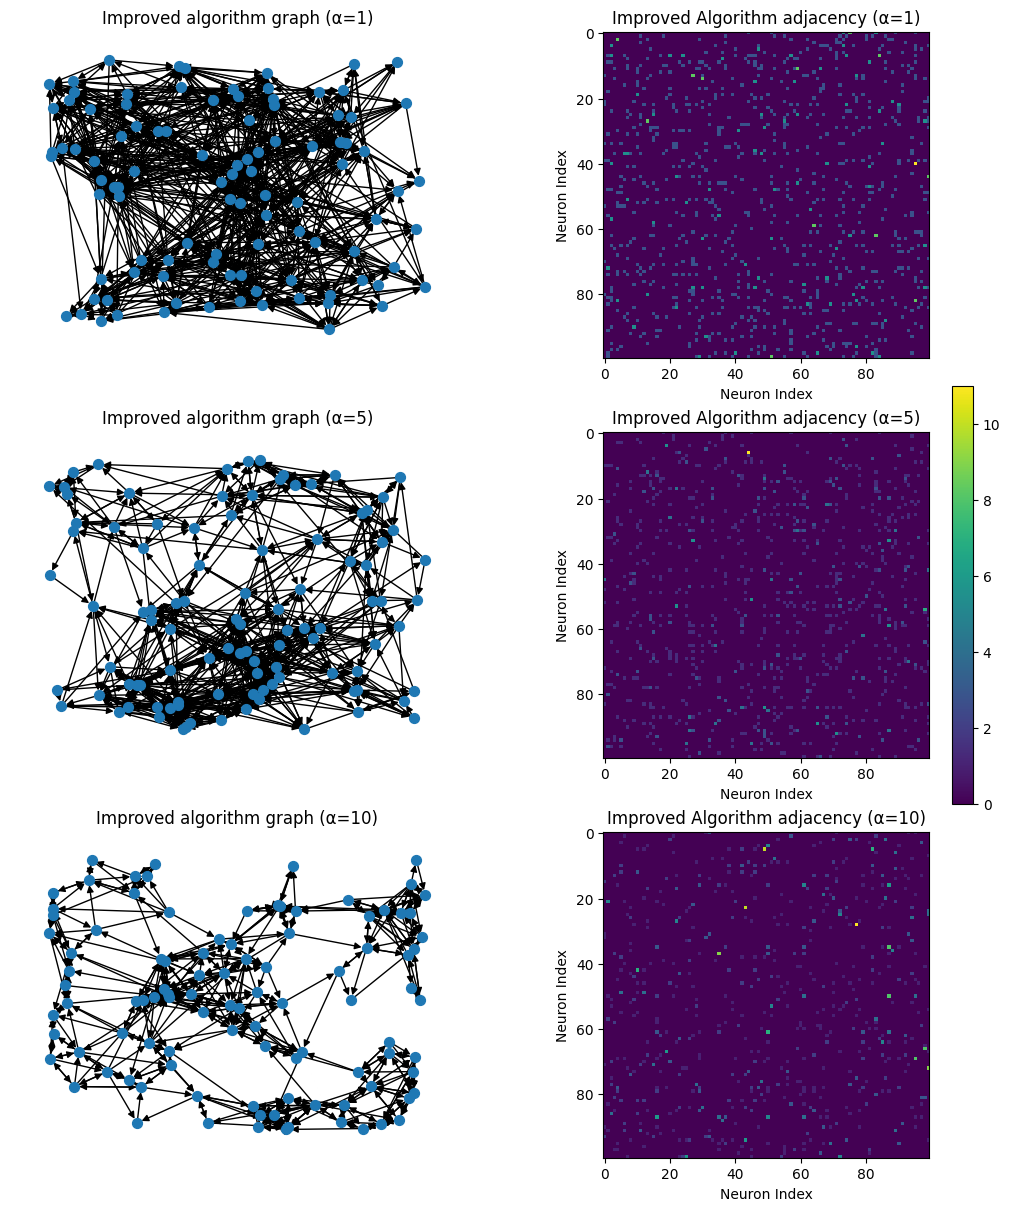

In [57]:
results = [
    ImprovedAlgorithmFast(alpha=5, N=100),
    ImprovedAlgorithmFast(alpha=10, N=100),
    ImprovedAlgorithmFast(alpha=20, N=100)
]

fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(10, 12))

for i, (adjacency, positions) in enumerate(results):
    G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)
    plot_graph( axes[i, 0],G,positions,title=f"Improved algorithm graph (α={alpha_values[i]})")
    im = plot_adjacency_matrix(axes[i, 1],adjacency,title=f"Improved Algorithm adjacency (α={alpha_values[i]})")
    
# optional single colorbar for all adjacency matrices
fig.colorbar(im, ax=axes[:, 1], fraction=0.046)

plt.show()


In [58]:
def avg_shortest_path_length_directed(G):
    lens = []
    for u in G.nodes():
        for v in G.nodes():
            if u != v:
                if nx.has_path(G,u,v):
                    l = nx.shortest_path_length(G,u,v,weight="dist")
                    #l = nx.shortest_path_length(G,u,v)
                    lens.append(l)
    n=len(lens)
    # print(sum(lens)/n)
    return sum(lens)/n

## Task 2.3

TODO pokec pokec pokec

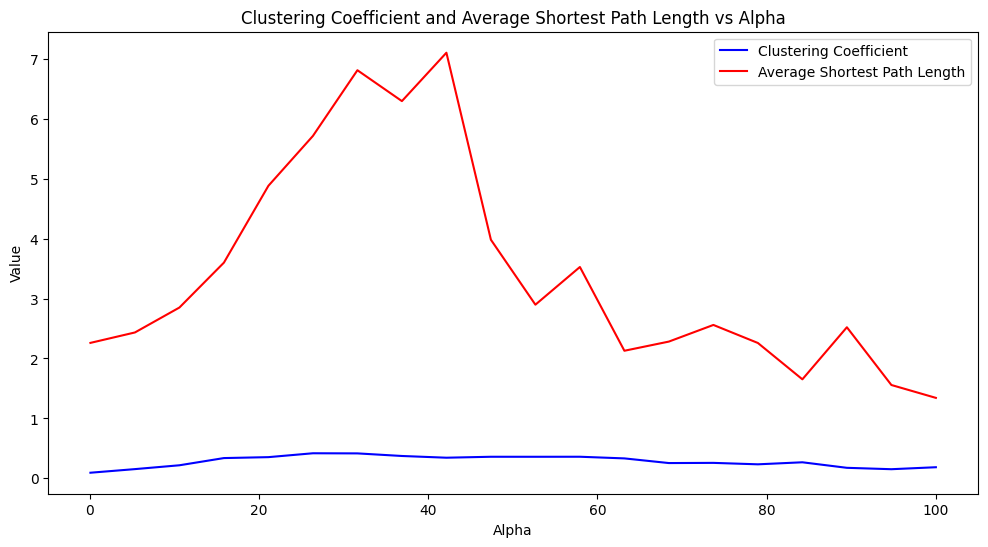

In [59]:
cluster_coefficients = []
average_shortest_paths = []
alphas = np.linspace(0.1, 100, 20)

for i, alpha in enumerate(alphas):
    print(f'Calculating for alpha {i+1}/{len(alphas)}', end='\r')
    adjacency, _ = ImprovedAlgorithmFast(alpha=alpha, N=100)
    G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)

    cluster_coefficients.append(nx.average_clustering(G))
    average_shortest_paths.append(avg_shortest_path_length_directed(G))

clear_output()
plt.figure(figsize=(12, 6))
plt.plot(alphas, cluster_coefficients, label='Clustering Coefficient', color='blue')
plt.plot(alphas, average_shortest_paths, label='Average Shortest Path Length', color='red')
plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Clustering Coefficient and Average Shortest Path Length vs Alpha')
plt.legend()
plt.show()


# Task 3

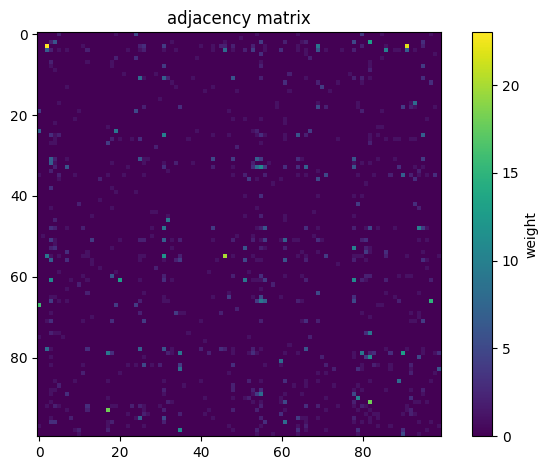

In [ ]:
#| include: false
mouse = np.load("data/mouse_V1_adjacency_matrix.npy")
#print(mouse.shape)

plt.figure()
plt.imshow(mouse)
plt.title("adjacency matrix")
plt.colorbar(label="weight")
plt.tight_layout()

## Task 3.1

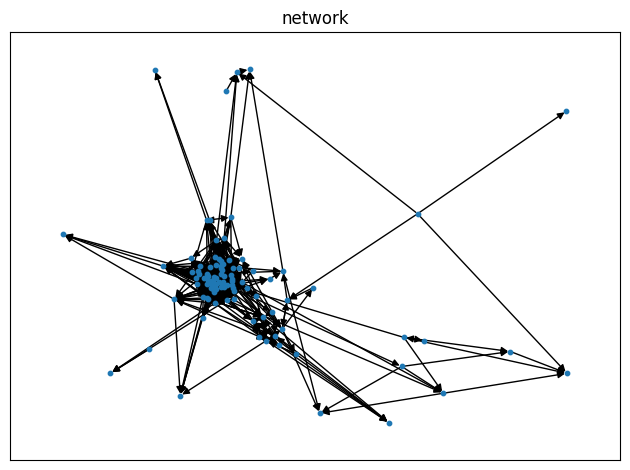

In [61]:
G = nx.from_numpy_array(mouse, create_using=nx.DiGraph)

plt.figure()

position = nx.spring_layout(G,seed=0)
nx.draw_networkx(G,pos=position,node_size=10,with_labels=False)
plt.title("network")
plt.tight_layout()
plt.show()   

## Task 3.2

TODO ori dik

In [62]:
c = nx.average_clustering(G)
a = avg_shortest_path_length_directed(G)
print(f"Avergae clustering is {round(c, 4)} and average shortest path length is {round(a, 4)}")

Avergae clustering is 0.2278 and average shortest path length is 2.6365


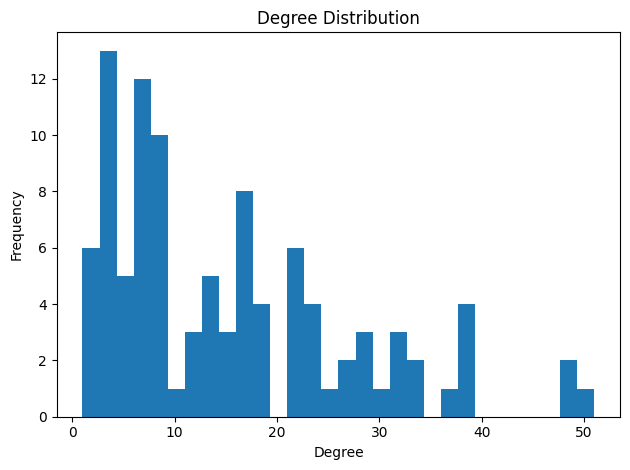

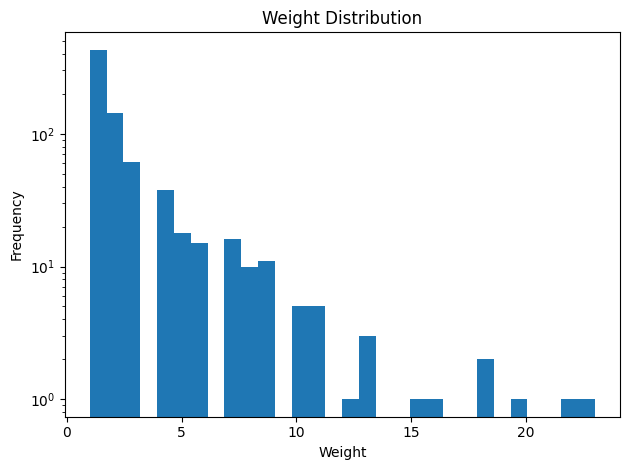

In [63]:
#weight and degree distributions
degrees = [val for (_, val) in G.degree()]
plt.figure()
plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

weights = [data['weight'] for (_, _, data) in G.edges(data=True)]
plt.figure()
plt.hist(weights, bins=30)      
plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")

plt.yscale("log")

plt.tight_layout()
plt.show()

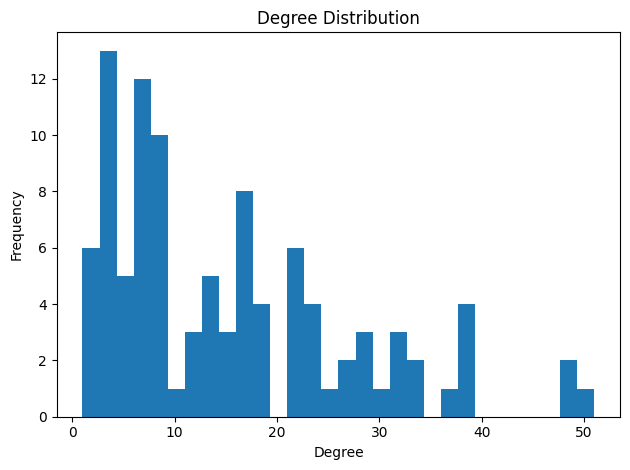

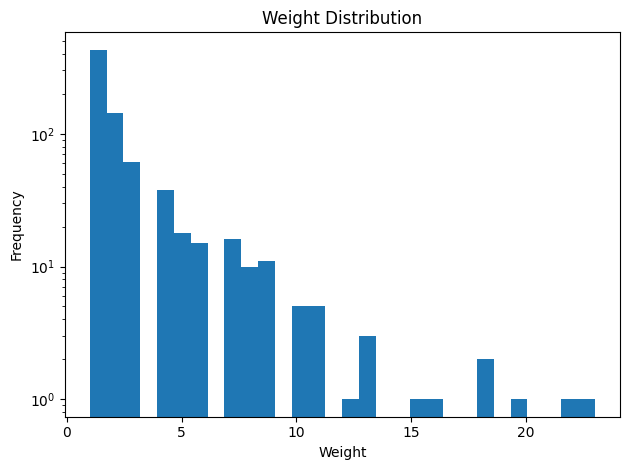

In [65]:
#weight and degree distributions
degrees = [val for (_, val) in G.degree()]
plt.figure()
plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

weights = [data['weight'] for (_, _, data) in G.edges(data=True)]
plt.figure()
plt.hist(weights, bins=30)      
plt.title("Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")

plt.yscale("log")

plt.tight_layout()
plt.show()

## 3.3

no buď tu len bude bunka, ktorú už som napísal
alebo oriho prehrotené bin polenie
